In [1]:
import random
random.seed(42)

In [2]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

In [4]:
import numpy as np 
import pandas as pd 
 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import  confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 

df = pd.read_csv('journeys.csv') 
targets = df['Conversion'] 
df.drop(['Journey Start Date', 'Journey End Date', 'Events Combo', 'User-Journey'], axis=1, inplace=True) 
df = pd.get_dummies(df) 
 
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.3) 
X_train.drop(['Conversion'], axis=1, inplace=True) 
X_test.drop(['Conversion'], axis=1, inplace=True) 

scaler = StandardScaler() 
scaler.fit(X_train) 
 
s_X_train = scaler.transform(X_train) 
s_X_test = scaler.transform(X_test) 

X_train = pd.DataFrame(s_X_train, columns = X_train.columns)
X_test = pd.DataFrame(s_X_test, columns = X_test.columns)

In [5]:
os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=os_data_X, columns=columns)
y_train = pd.DataFrame(data=os_data_y, columns=['Conversion'])

In [6]:
param_grid = { 
    'min_samples_split': [3, 5, 10],  
    'n_estimators' : [300], 
    'max_depth': [3, 5, 15, 25], 
    'max_features': [3, 5, 10, 19]

} 
  
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
def grid_search_wrapper(_model = '', param_grid=param_grid): 
    grid_search = GridSearchCV(_model, param_grid, scoring=make_scorer(f1_score),
        return_train_score=True, n_jobs=-1, error_score='raise', cv=10) 
    grid_search.fit(X_train.values, y_train.values) 
 
    # make the predictions 
    y_pred = grid_search.predict(X_test.values) 
 
    print('Best params for {}'.format('f1')) 
    print(grid_search.best_params_) 
 
    # confusion matrix on the test data. 
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('f1')) 
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    return grid_search

def show_model_output(grid_search_output, num_to_show = 10): 
    try:
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df2 = pd.DataFrame(grid_search_output.cv_results_['mean_train_score']).rename(columns={0: "mean_train_score"})
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_test_score"})
        result = pd.concat([df2,df3,df1], axis = 1).sort_values(by='mean_test_score', ascending=False)
        result = result.head(num_to_show)
    except Exception:
    ## for some reason logistic regression doesnt have mean_train_score
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_test_score"})
        result = pd.concat([df3,df1], axis = 1).sort_values(by='mean_test_score', ascending=False)
        result = result.head(num_to_show)
    return result



### Random Forest

In [7]:
clf = RandomForestClassifier(n_jobs=-1)
grid_search_clf = grid_search_wrapper(_model = clf, param_grid=param_grid) 
#y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best params for f1
{'max_depth': 15, 'max_features': 19, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1837        64
pos       128       209


In [8]:
show_model_output(grid_search_output= grid_search_clf, num_to_show=10)

,mean_train_score,mean_test_score,max_depth,max_features,min_samples_split,n_estimators
34,0.865982,0.845954,15,19,5,300
32,0.861318,0.845186,15,10,10,300
44,0.862178,0.844873,25,10,10,300
43,0.866540,0.844684,25,10,5,300
25,0.862512,0.844606,15,3,5,300
30,0.866948,0.844573,15,10,3,300
26,0.859395,0.844560,15,3,10,300
28,0.863332,0.844407,15,5,5,300
46,0.867460,0.844406,25,19,5,300
31,0.864506,0.844226,15,10,5,300


### Logistic Regression

In [9]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

In [10]:
logreg = LogisticRegression(random_state=42)
log_reg = GridSearchCV(logreg, param_grid=param_grid, scoring=make_scorer(f1_score), cv=10)
log_reg.fit(X_train, y_train)

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWar

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring=make_scorer(f1_score))

In [11]:
show_model_output(grid_search_output= log_reg, num_to_show=10)

,mean_test_score,C,penalty,solver
8,0.688631,0.010,l1,liblinear
14,0.687365,0.100,l1,liblinear
17,0.686686,0.100,l2,liblinear
5,0.686355,0.001,l2,liblinear
20,0.686181,1.000,l1,liblinear
11,0.685848,0.010,l2,liblinear
34,0.685728,100.000,l2,lbfgs
29,0.685728,10.000,l2,liblinear
32,0.685728,100.000,l1,liblinear
33,0.685728,100.000,l2,newton-cg


In [12]:
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [13]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [14]:
grid_search_xgb = grid_search_wrapper(_model = xgb, param_grid=param_grid) 

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

[08:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params for f1
{'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1834        67
pos       124       213


In [15]:
show_model_output(grid_search_output= grid_search_xgb, num_to_show=10)

,mean_train_score,mean_test_score,C,penalty,solver
0,0.859637,0.851497,0.001,l1,newton-cg
31,0.859637,0.851497,100.000,l1,lbfgs
23,0.859637,0.851497,1.000,l2,liblinear
24,0.859637,0.851497,10.000,l1,newton-cg
25,0.859637,0.851497,10.000,l1,lbfgs
26,0.859637,0.851497,10.000,l1,liblinear
27,0.859637,0.851497,10.000,l2,newton-cg
28,0.859637,0.851497,10.000,l2,lbfgs
29,0.859637,0.851497,10.000,l2,liblinear
30,0.859637,0.851497,100.000,l1,newton-cg


### SHAP

##### Random Forest

In [53]:
import shap
model = grid_search_clf.best_estimator_.fit(X_train, y_train.values.ravel())
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


In [54]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1901
           1       0.76      0.62      0.68       337

    accuracy                           0.91      2238
   macro avg       0.85      0.79      0.81      2238
weighted avg       0.91      0.91      0.91      2238



In [55]:
import matplotlib.pyplot as plt

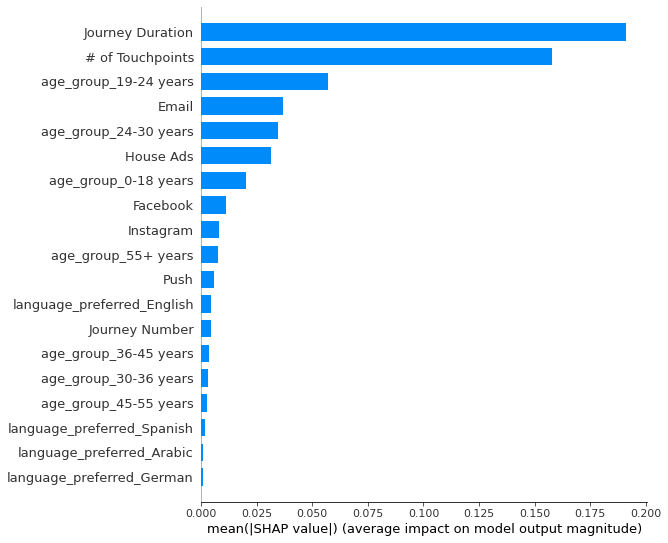

In [56]:
shap.summary_plot(shap_values[1], X_train, plot_type = 'bar', class_names=model.classes_)

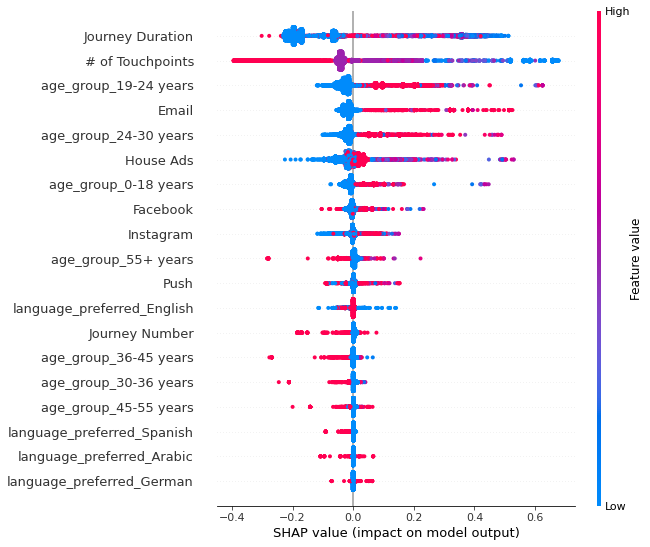

In [57]:
shap.summary_plot(shap_values[1], X_train, class_names=model.classes_)

##### Logistic Regression

In [58]:
model = log_reg.best_estimator_.fit(X_train, y_train.values.ravel())
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_train)

In [59]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1901
           1       0.28      0.67      0.40       337

    accuracy                           0.70      2238
   macro avg       0.60      0.68      0.60      2238
weighted avg       0.83      0.70      0.74      2238



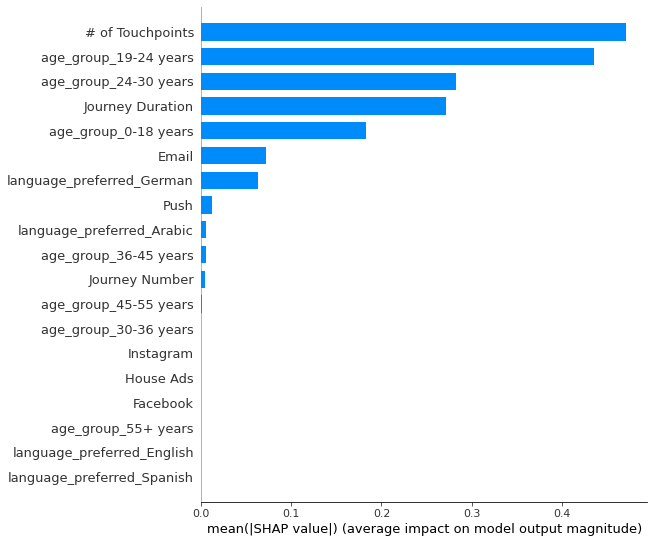

In [60]:
plt.figure(figsize=((10,8)))
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=model.classes_, show=False)

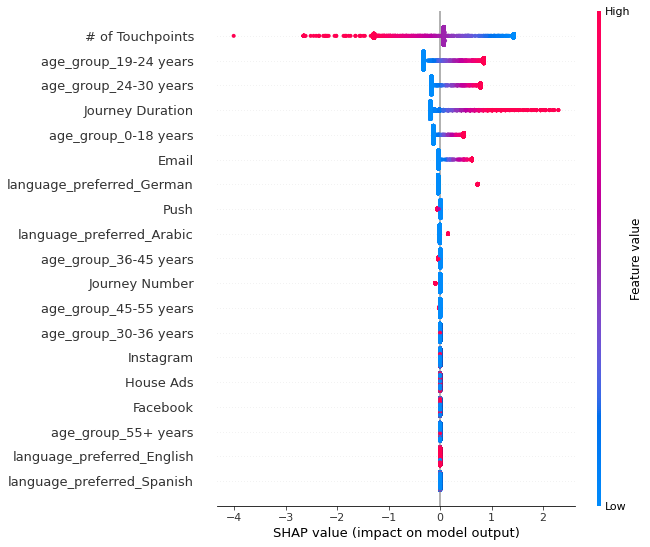

In [61]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model.classes_)

##### XGBooost

In [62]:
model = grid_search_xgb.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[09:09:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:09:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|===================| 9019/9036 [01:14<00:00]        

In [63]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1901
           1       0.76      0.63      0.69       337

    accuracy                           0.91      2238
   macro avg       0.85      0.80      0.82      2238
weighted avg       0.91      0.91      0.91      2238



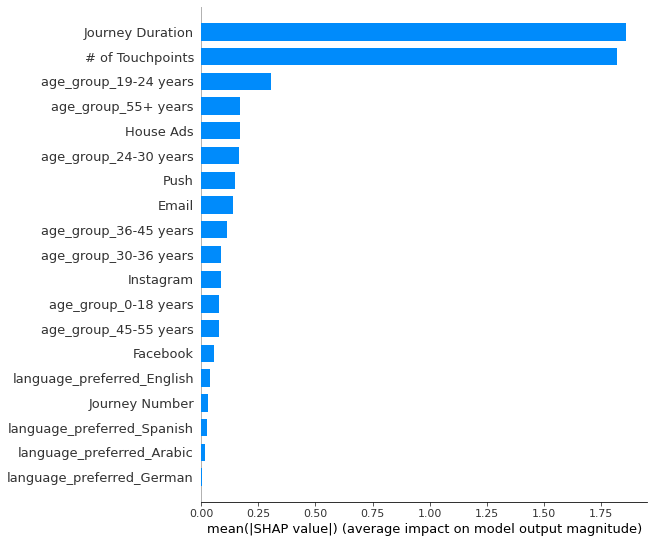

In [64]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

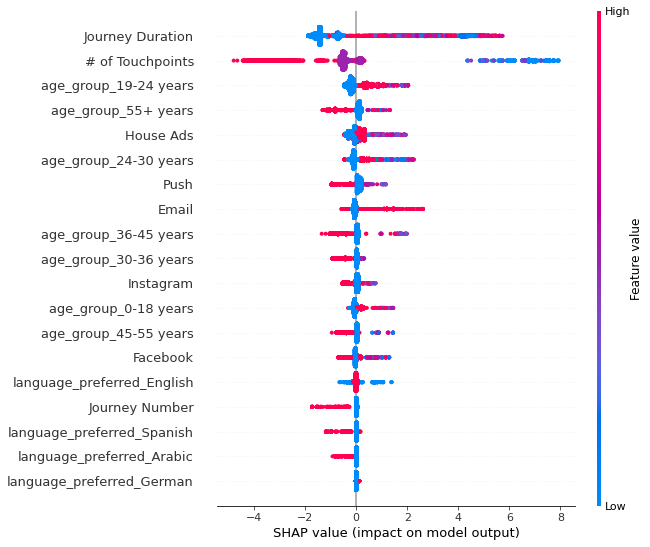

In [65]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model.classes_)